In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

In [24]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.facecolor'] = 'white'

### ЗАДАЧА
Имеются данные по опробованию скважин с указанием содержания полезного компонента Fe и содержания сопутствующего полезного компонента Si.
Укрупненные интервалы опробования описаны геологом и определена геологическая порода LITH (задана кодом).<br>
Необходимо проанализировать исходные данные. Попробовать определить взаимосвязь зависимой переменной Fe от независимой переменной Si посредством построения регрессионной модели. Оценить возможное влияние категориальной переменной LITH на зависимые переменные Fe, Si
### РЕШЕНИЕ

Загрузим наши данные в датафреймы pandas

In [42]:
INPUT_FILE = "D:\Cloud\Git\geekbrains-theory-of-chances\coursework\data.xls"
#https://github.com/mmingalov/geekbrains-theory-of-chances/tree/master/coursework

SHEET_NAME_ASSAY = "assay"
SHEET_NAME_LITH = "lith"
df_assay = pd.read_excel(INPUT_FILE,sheet_name= SHEET_NAME_ASSAY)
df_lith = pd.read_excel(INPUT_FILE,sheet_name= SHEET_NAME_LITH)

__соберем единый датасет из двух исходных__
для этого выполним небольшую процедуру, которая проставит пробам соответсвующий интервалу опробования литологический код<br>
необходимость этого связана с тем, что геологические породы описаны по более укрупненным интервалам, и некоторые интервалы пород включают несколько проб

In [43]:
df_assay['lith'] = ""

N_assay = df_assay.shape[0]
for i in range(0,N_assay):
    assay_hole_id = df_assay.loc[i,"HOLE_ID"]
    assay_from = df_assay.loc[i,"FROM"]
    assay_to = df_assay.loc[i,"TO"]
    
    dfl = df_lith[df_lith["HOLE_ID"]==assay_hole_id].reset_index()
    N_lith = dfl.shape[0]
    
    for j in range(0,N_lith):
        lith_from = dfl.loc[j,"FROM"]
        lith_to = dfl.loc[j,"TO"]
        if(assay_from>=lith_from)&(assay_to<=lith_to):
            df_assay.loc[i,'lith']=dfl.loc[j,'LITH']
            break

In [47]:
df = df_assay
#df[df['T_Fe'].isnull()==False]

__Сейчас наш результирующий датасет включает всю информацию__

In [48]:
df.describe()

,FROM,TO,INT,T_Fe,SiO2
count,6568.000000,6568.000000,6568.000000,5561.000000,3156.000000
mean,325.402171,330.925942,5.523771,36.260504,12.024800
std,125.679376,122.296122,17.916386,15.605884,9.100951
min,0.000000,0.700000,0.340000,4.000000,0.015000
25%,252.235000,257.982500,1.910000,23.820000,4.107500
50%,336.015000,339.275000,2.000000,34.300000,10.900000
75%,411.147500,414.635000,2.940000,48.800000,18.202500
max,678.830000,739.040000,600.110000,70.060000,58.880000


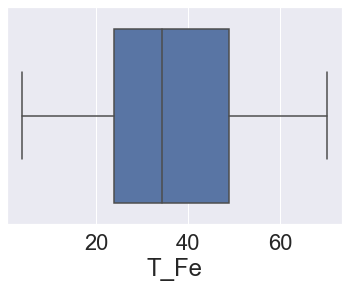

In [50]:
#pd.DataFrame(df["T_Fe"]).boxplot()
sns.boxplot(df["T_Fe"], orient='h')
plt.show()

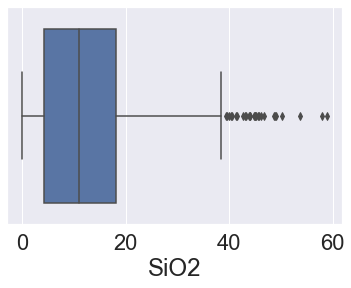

In [51]:
sns.boxplot(df["SiO2"], orient='h')
plt.show()

Проверим распределение наших перменных

C:\Users\mmingalov\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\mmingalov\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


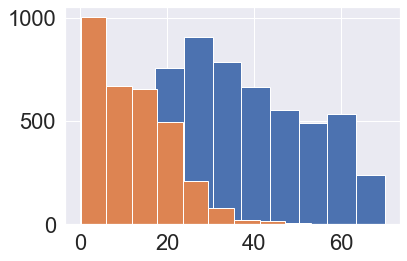

In [52]:
plt.hist(df['T_Fe']);
plt.hist(df['SiO2']);

проведем построение через альтернативный инструментарий

In [80]:
#откинем строки с пустыми содержаниями
df.loc[df['T_Fe'].isnull()==False, 'T_Fe']

2        8.31
3       35.88
4       39.73
5       51.89
6       46.38
        ...  
6557     9.20
6558    34.20
6559    21.38
6560     7.90
6561    11.00
Name: T_Fe, Length: 5561, dtype: float64

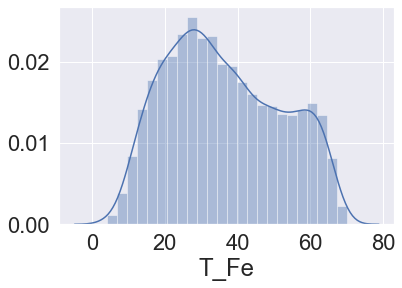

In [54]:
##откинем строки с пустыми содержаниями -- данные пробы не были опробованы лабораторией
sns.distplot(df.loc[df['T_Fe'].isnull()==False, 'T_Fe'])

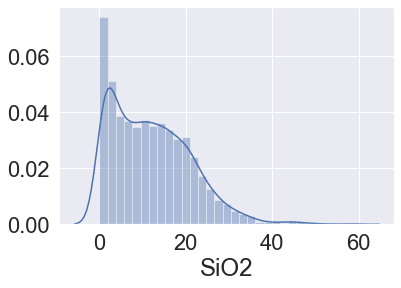

In [55]:
sns.distplot(df.loc[df['SiO2'].isnull()==False, 'SiO2'])

__распределение обоих переменных не походит на нормальное__

Попробуем определить корреляцию между содержаниями (Fe и Si). Для этого построим матрицу корреляций ВСЕХ количественных переменных в нашем наборе данных.

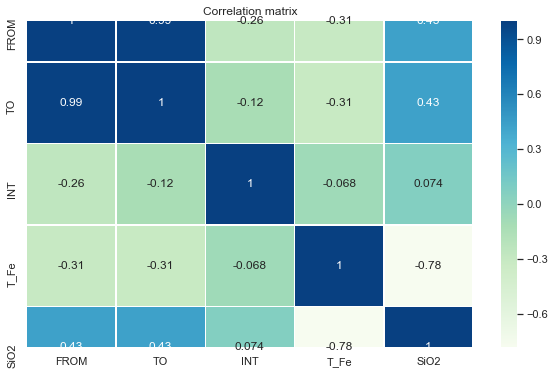

In [76]:
plt.figure(figsize = (10,6))

sns.set(font_scale=1)
sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Из данной матрицы мы понимаем, что содержание не зависит от параметров глубин интервала опробования и длины данного интервала. Корреляция между Fe и Si, равная -0.78 имеет смысл и говорит нам о наличии взаимосвязи между переменными.

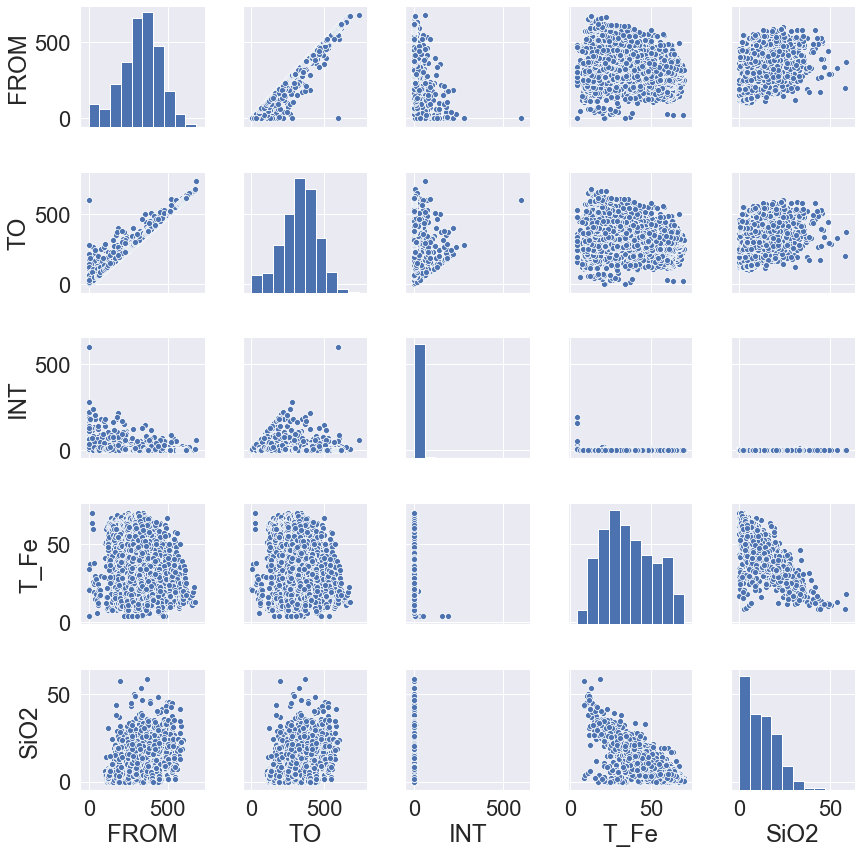

In [57]:
sns.pairplot(df)

Из всех вышеуказанных графиков нас будет интересовать именно T_Fe -- SiO2 <br>
Построим его ниже покрупнее, воспользовавшись другим инструментарием

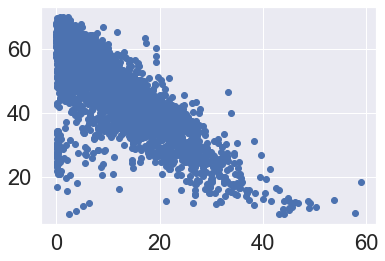

In [58]:
plt.scatter(df['SiO2'], df['T_Fe'])

График в общем виде походит на линейный. <br>
Коэффициент корреляции Пирсона r=-0.78, рассчитанный выше, так же говорит нам о наличии связи между переменными.

__Построим модель линейной регрессии__

в нашем наборе данных df не у всех проб проставлено содержание. Мы его не знаем. Вернее, мы не можем сказать точно по какой причине отсутствует значение -- либо оно ниже пределов обнаружения лабораторного метода, либо пробы вообще не анализировались лабораторией. Данные пропуски в идеале нужно обработать, чтобы строить модель. Но задать им значения НОЛЬ -- не выход. Более праивильно избаиться совсем от таких строк

In [92]:
#для построения модели будем брать только те строки
#x1 = np.array(df['SiO2'])
x1 = np.array(df.loc[((df['T_Fe'].isnull()==False) & (df['SiO2'].isnull()==False)), 'SiO2'])

#y1 = np.array(df['T_Fe'])
y1 = np.array(df.loc[((df['T_Fe'].isnull()==False) & (df['SiO2'].isnull()==False)), 'T_Fe'])

x1.shape[0], y1.shape[0]

(3156, 3156)

In [93]:
b1 = np.cov(x1, y1, ddof=0)[0, 1] / np.var(x1, ddof=0) 
#Замечание. В данной формуле не нужно обязательно использовать смещённую или несмещённую оценку, 
#но важно, конечно, использовать один и тот же тип оценки и для ковариации, и для дисперсии.
b1

-1.0780218576437075

In [94]:
b0 = y1.mean() - b1 * x1.mean()
b0

58.6832853002017

__Построим scatter plot по данным и отметим на нём прямую линейной регрессии__

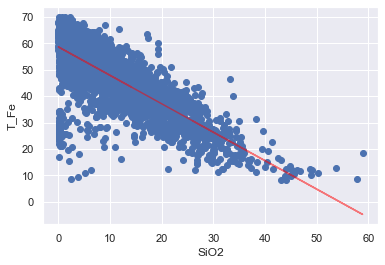

In [95]:
ox = x1
oy = b0 + b1 * ox

plt.scatter(x1, y1)
plt.plot(ox, oy, color='red', alpha=0.5)

plt.xlabel('SiO2')
plt.ylabel('T_Fe');

In [96]:
z1 = b0 + b1 * x1

np.vstack([y1, z1]).T[:5]

array([[35.88      , 43.48317711],
       [39.73      , 53.71360454],
       [51.89      , 57.27107667],
       [46.38      , 58.1011535 ],
       [62.75      , 58.65094464]])

In [97]:
#Коэффициент детерминации
R1 = 1 - (z1 - y1).var() / y1.var()
R1

0.6093092861801815

In [99]:
#Коэффициент корреляции
np.corrcoef(x1, y1)[0,1]

-0.7805826581344104

__средняя ошибка аппроксимации__ вычисляется по формуле:
$$\overline{A} = \frac{1}{n} \displaystyle\sum_{i=1}^{n} \Bigl| {{\frac{y_i - z_i}{y_i}} \Bigr|}.$$

Если $\overline{A}$ не превышает $8$-$10 \%$, можно сказать, что теоретические значения близки к тем, которые выдает модель линейной регрессии.

In [101]:
def mean_approximation_error(y_real: np.ndarray, y_pred: np.ndarray) -> float:
    """Средняя ошибка аппроксимации.
    """
    
    return np.abs((y_real - y_pred) / y_real).mean()

In [102]:
mean_approximation_error(y1, z1)

0.15132841526349844

Наша __средняя ошибка аппроксимации__ превышает 10%, что говорит о том, что теоретические значения недостаточно близки к тем, которые выдет модель линейной регрессии

__ВЫВОД:__ тем не менее из значений коэффициентов корреляции и детерминации можно сделать вывод о том, что есть связь между содержаниями SiO2 и T_Fe. Присутствие SiO2 в пробе может указаывать нам на определенное содержание T_Fe в данном интервале опробования.

### Обзор категориальной переменной
выявим множество значений категориальной переменной LITH, получив его из проб с непустыми содержаниями по T_Fe и SiO2 

In [108]:
df[(df['SiO2']>0)&(df['T_Fe']>0)]['lith'].value_counts()


BMt    1117
DMt     649
DHe     586
SMt     131
BHe     109
GMt     105
GdP      83
GHe      80
SHe      73
Ssr      64
BPy      31
Pan      22
Dsr      13
Dpy      12
Tub       8
Bsr       6
Gsr       5
Aaa       5
GPy       5
SQz       4
Tuu       4
Fhe       3
Sik       3
Bre       3
San       2
Spy       1
Lll       1
Ehe       1
GNt       1
Dgp       1
Ssg       1
Name: lith, dtype: int64

In [104]:
df2 = df[(df['SiO2']>0)&(df['T_Fe']>0)]
df2

,HOLE_ID,FROM,TO,INT,T_Fe,SiO2,CODE,lith
3,DDH1,109.79,114.29,4.50,35.88,14.10,m1,DMt
4,DDH1,114.29,117.22,2.93,39.73,4.61,m1,GMt
5,DDH1,117.22,120.80,3.58,51.89,1.31,m1,GMt
6,DDH1,120.80,123.71,2.91,46.38,0.54,m1,GMt
7,DDH1,123.71,128.63,4.92,62.75,0.03,m1,BMt
...,...,...,...,...,...,...,...,...
6476,RCH84,542.36,544.36,2.00,36.32,13.51,NaN,DHe
6477,RCH84,544.36,546.71,2.35,32.35,8.69,NaN,DHe
6478,RCH84,546.71,548.71,2.00,20.65,2.61,NaN,GdP
6479,RCH84,548.71,550.00,1.29,19.60,1.84,NaN,GdP


Можно попробовать применить однофакторный дисперсионный анализ и исследовать флияние категориальной переменной на количественные переменные.

### исследуем влияние LITH на SiO2

Сформулируем гипотезу $H_{0}$  -- "фактор LITH не влияет на значение содержания SiO2"
переменная будет иметь k групп

In [109]:
#df3 = pd.concat([df2, pd.get_dummies(df2['lith'])], axis=1)
#df3.head()

In [110]:
#df3.corr()

plt.figure(figsize = (48,36))

sns.set(font_scale=1.4)
sns.heatmap(df3.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()